In [7]:
# ds = load_dataset("miladfa7/Brain-MRI-Images-for-Brain-Tumor-Detection")
import os
import sklearn
import glob,shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datasets import load_dataset

data='BrainMRImages'  #Data Folder
classes=['adnoma','Gliomas','Meningioma','No_tumor']

len(os.listdir(data))

6

In [2]:
ad='BrainMRImages/adnoma'
gl='BrainMRImages/Gliomas'
mn='BrainMRImages/Meningioma'
no='BrainMRImages/no_tumor'

print(f"There are total {len(os.listdir(ad))} cases of adnoma tumor")
print(f"There are total {len(os.listdir(gl))} cases of Gliomas tumor")
print(f"There are total {len(os.listdir(mn))} cases of Meningioma tumor")
print(f"There are total {len(os.listdir(no))} cases where no tumor was identified")

There are total 414 cases of adnoma tumor
There are total 459 cases of Gliomas tumor
There are total 414 cases of Meningioma tumor
There are total 401 cases where no tumor was identified


Creating Testing and Training folders

In [3]:
train=os.path.join(data,'train')
test=os.path.join(data,'test')

os.makedirs(train,exist_ok=True)
os.makedirs(test,exist_ok=True)

for cl in classes:
    os.makedirs(os.path.join(train,cl),exist_ok=True)
    os.makedirs(os.path.join(test,cl),exist_ok=True)

In [4]:
from sklearn.model_selection import train_test_split

for cl in classes:
    cl_path=os.path.join(data,cl)
    images=os.listdir(cl_path)
    
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    for image in test_images:  # This should be test_images instead of train_images
        src = os.path.join(cl_path, image)
        dst = os.path.join(test, cl, image)
        shutil.copyfile(src, dst)

        
    for image in train_images:
        src=os.path.join(cl_path,image)
        dst=os.path.join(train,cl,image)
        shutil.copyfile(src,dst)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,rotation_range=20,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_data_gen.flow_from_directory(
    directory=train,
    target_size=(150, 150),
    batch_size=32,  # Define the batch size
    class_mode='categorical',
    shuffle=True
)

test_generator = test_data_gen.flow_from_directory(
    directory=test,
    target_size=(150, 150),
    batch_size=32,  # Define the batch size
    class_mode='categorical',
    shuffle=True
)


Found 1349 images belonging to 4 classes.
Found 1688 images belonging to 4 classes.


In [6]:
import matplotlib.pyplot as plt

train_imgs,_=next(train_generator)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

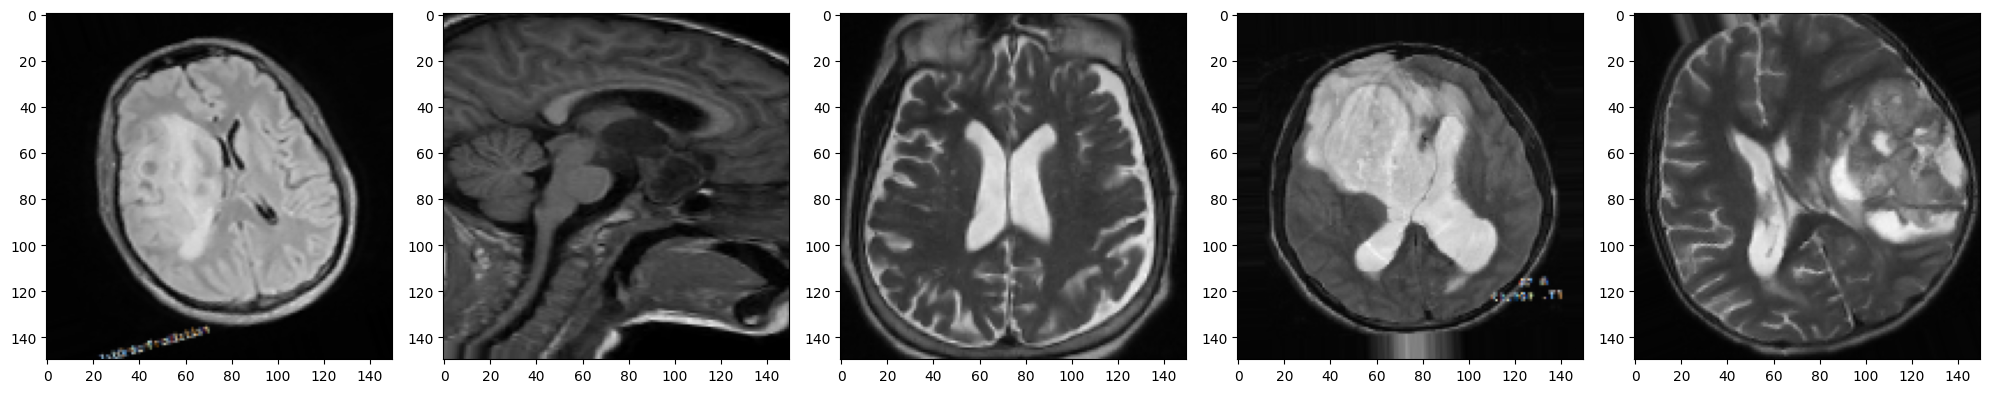

In [7]:
plotImages(train_imgs[:5])  # Plot images 0-4

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,660 (13.18 MB)

 Trainable params: 3,454,660 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
test_data, test_labels = next(test_generator)

print(type(train_imgs))  # Should be numpy.ndarray
print(type(_))  # Should be numpy.ndarray

if train_imgs is None or _ is None:
  # Handle the case where data generation fails 
  raise Exception("Data generator not returning data")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [12]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=test_generator
    # callbacks=[checkpoint, early_stopping]
)


Epoch 1/25


c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/43 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.2106 - loss: 1.5018

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


43/43 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.2697 - loss: 1.4190 - val_accuracy: 0.3519 - val_loss: 1.2844
Epoch 2/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.4347 - loss: 1.2080 - val_accuracy: 0.5569 - val_loss: 1.0391
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4855 - loss: 1.1487 - val_accuracy: 0.5942 - val_loss: 0.9672
Epoch 4/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5535 - loss: 1.0334 - val_accuracy: 0.6025 - val_loss: 0.9821
Epoch 5/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5695 - loss: 1.0046 - val_accuracy: 0.6179 - val_loss: 0.8789
Epoch 6/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6024 - loss: 0.9256 - val_accuracy: 0.6368 - val_loss: 0.8243
Epoch 7/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6171 - loss: 0.9033 - val_accuracy: 0.6410 - val_loss: 0.8222
Epoch 8/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.6480 - loss: 0.8569 - val_accuracy: 0.6517 - val_loss: 0.784

In [13]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy}')

53/53 ━━━━━━━━━━━━━━━━━━━━ 27s 500ms/step - accuracy: 0.8493 - loss: 0.3681
Test accuracy: 0.8388625383377075


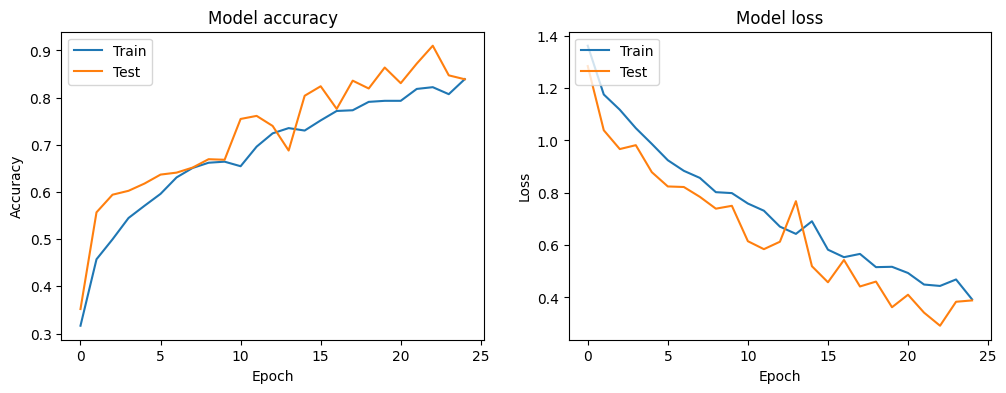

In [14]:
import matplotlib.pyplot as plt

# Accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

#Loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


In [15]:
model.save('MRI Images Classifier.keras') 

In [9]:
import cv2 as cv
import numpy as np

image_path = '3.jpg'  #I had path issues, So I took this image out of the test directory.ke
image = cv.imread(image_path)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image = cv.resize(image, (150, 150))  
image = image / 255.0  
image = np.expand_dims(image, axis=0)

In [12]:
from tensorflow.keras.models import load_model
import cv2 as cv

model = load_model('MRI Images Classifier.keras')
predictions = model.predict(image)

predicted_class_index = np.argmax(predictions)

predicted_class_name = classes[predicted_class_index]

print(f'The model predicts that the image is: {predicted_class_name}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
The model predicts that the image is: Meningioma


In [15]:
import imdb

Im=imdb.IMDb()

name=input("Movie NamE:")
movies=Im.search_movie(str(name))
index=movies[0].getID()
movie=Im.get_movie(index)
title=movie['title']
year=movie['year']
cast=movie['cast']
list_of_cast=','.join(map(str,cast))

print(f"Title : {title}")
print(f"Title : {year}")
print(f"Title : {cast}")
print(f"Title : {list_of_cast}")

ModuleNotFoundError: No module named 'imdb'